In [ ]:
!pip install rasterio

In [ ]:
!pip install geopandas

In [ ]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
4 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Ca

#**RANDOM FOREST CODE IN PYTHON TRAINING AND TESTING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Import the required library**

In [ ]:
from __future__ import print_function

import shapely.geometry

from osgeo import gdal,ogr,osr, gdal_array
import numpy as np
import pandas as pd
import scipy as sp
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
from pyproj import CRS
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.features import geometry_mask
import fiona
from affine import Affine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

gdal.UseExceptions()

##**Functions**

In [ ]:
def invalid_file(file):
    if file is None:
        print(f"The file {file} could not be opened")
        sys.exit(-1)

In [ ]:
def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False


####**Spatial Index Functions**

In [ ]:
def NDVI(filename,filesavepath):

    # OPEN THE FINAL RASTER FILE OF THE AREA OF STUDY
    image = rasterio.open(filename)

    # CHECK IF THE FILE WAS CORRECTLY OPENED
    invalid_file(filename)

    # EXTRACT THE RED AND NIR BANDS
    red = image.read(3)
    nir = image.read(7)

    NDVI_CRS = image.crs
    NDVI_TRANSFORM = image.transform


    # CHANGE OF THE TYPE OF THE VALUES CONTAINED IN RED AND NIR FROM UINT16 TO FLOAT
    red = red.astype(np.float32)
    nir = nir.astype(np.float32)

    # IT IS IMPOSSIBLE TO DIVIDE BY ZERO
    # BUT IN OUR ARRAYS, WE HAVE SOME VALUES AT ZERO
    # SO WE NEED TO ALLOW NUMPY TO DIVIDE BY ZERO

    # ALLOW THE COMPILATOR TO SKIP THE ERROR OF DIVIDING BY ZERO
    np.seterr(divide="ignore", invalid="ignore")

    NDVI = np.empty(image.shape, dtype=rasterio.float32)



    # VERITY TABLE FOR OR OPERATOR
    # WE CREATE A FILTER WHERE WE CALCULATE THE VALUES ON SUCH PIXELS THAT
    # HAVE A VALUE > 0
    NDVI_CHECK = np.logical_or(red > 0, nir > 0)


    # WE APPLY THE FILTER TO CALCULATE THE NDVI INDEX
    NDVI = np.where(NDVI_CHECK, (nir - red) / (nir + red), -999)

    # LOOK AT VEGETATION INDEXES TO HAVE AN IDEA HOW THE DATA ARE  DISTRIBUTED
    print(f"NDVI MEAN {NDVI.mean()}")
    print(f"NDVI STD {NDVI.std()}")

    show(NDVI,cmap="RdYlGn", vmin=-1, vmax=1, title="NDVI")

    NDVI_PATH = filesavepath

    NDVI_META = image.meta

    # Create a mask to filter out pixels with a value of -999
    valid_mask = NDVI != -999

    # Apply the mask to the NDVI array to remove -999 values
    NDVI_cleaned = np.where(valid_mask, NDVI, np.nan)  # Set -999 values to NaN


    ##Create a rasterio dataset and save the numpy array NDVI as a tiff file
    with rasterio.open(
            NDVI_PATH,
            'w',
            driver='GTiff',
            height=NDVI_cleaned.shape[0],
            width=NDVI_cleaned.shape[1],
            count=1,
            dtype=NDVI_cleaned.dtype,
            crs=image.crs,
            transform=image.transform,
    ) as dest1:
        dest1.write(NDVI_cleaned, 1)

    dest1.close()
    image = None

    return NDVI_cleaned

def GNDVI(filename,filesavepath):

    # OPEN THE RASTER FILE
    image = rasterio.open(filename)

    # CHECK IF THE FILE WAS CORRECTLY OPENED
    invalid_file(filename)

    # EXTRACT THE GREEN AND NIR BANDS
    nir = image.read(7)
    green = image.read(2)

    GNDVI_CRS = image.crs
    GNDVI_TRANSFORM = image.transform


    # CHANGE OF THE TYPE OF THE VALUES CONTAINED IN RED AND NIR FROM UINT16 TO FLOAT
    nir = nir.astype(np.float32)
    green= green.astype(np.float32)

    # IT IS IMPOSSIBLE TO DIVIDE BY ZERO
    # BUT IN OUR ARRAYS, WE HAVE SOME VALUES AT ZERO
    # SO WE NEED TO ALLOW NUMPY TO DIVIDE BY ZERO

    # ALLOW THE COMPILATOR TO SKIP THE ERROR OF DIVIDING BY ZERO
    np.seterr(divide="ignore", invalid="ignore")

    GNDVI = np.empty(image.shape, dtype=rasterio.float32)



    # VERITY TABLE FOR OR OPERATOR
    # WE CREATE A FILTER WHERE WE CALCULATE THE VALUES ON SUCH PIXELS THAT
    # HAVE A VALUE > 0
    GNDVI_CHECK = np.logical_or(nir > 0, green > 0)


    # WE APPLY THE FILTER TO CALCULATE THE GNDVI INDEX
    GNDVI = np.where(GNDVI_CHECK, (nir - green) / (nir + green), -999)



    show(GNDVI, cmap="Blues", vmin=-1, vmax=1, title="GNDVI")
    GNDVI_PATH = filesavepath

    GNDVI_META = image.meta


    ##Create a rasterio dataset and save the numpy array GNDVI as a tiff file
    with rasterio.open(
            GNDVI_PATH,
            'w',
            driver='GTiff',
            height=GNDVI.shape[0],
            width=GNDVI.shape[1],
            count=1,
            dtype=GNDVI.dtype,
            crs=image.crs,
            transform=image.transform,
    ) as dest1:
        dest1.write(GNDVI, 1)

    dest1.close()
    image = None

    return GNDVI

def NDWI1(filename,filesavepath):

    # OPEN THE RASTER FILE
    image = rasterio.open(filename)

    # CHECK IF THE FILE WAS CORRECTLY OPENED
    invalid_file(filename)

    # EXTRACT THE NIR AND SWIR BANDS
    nir = image.read(7)
    swir = image.read(9)


    # CHANGE OF THE TYPE OF THE VALUES CONTAINED IN RED AND NIR FROM UINT16 TO FLOAT
    nir = nir.astype(np.float32)
    swir= swir.astype(np.float32)

    # IT IS IMPOSSIBLE TO DIVIDE BY ZERO
    # BUT IN OUR ARRAYS, WE HAVE SOME VALUES AT ZERO
    # SO WE NEED TO ALLOW NUMPY TO DIVIDE BY ZERO

    # ALLOW THE COMPILATOR TO SKIP THE ERROR OF DIVIDING BY ZERO
    np.seterr(divide="ignore", invalid="ignore")

    NDWI1 = np.empty(image.shape, dtype=rasterio.float32)



    # VERITY TABLE FOR OR OPERATOR
    # WE CREATE A FILTER WHERE WE CALCULATE THE VALUES ON SUCH PIXELS THAT
    # HAVE A VALUE > 0
    NDWI1_CHECK = np.logical_or(nir > 0, swir > 0)


    # WE APPLY THE FILTER TO CALCULATE THE GNDVI INDEX
    NDWI1 = np.where(NDWI1_CHECK, (nir - swir) / (nir + swir), -999)



    show(NDWI1, cmap="Blues", vmin=-1, vmax=1, title="NDWI1")
    NDWI1_PATH = filesavepath

    NDWI1_META = image.meta


    ##Create a rasterio dataset and save the numpy array GNDVI as a tiff file
    with rasterio.open(
            NDWI1_PATH,
            'w',
            driver='GTiff',
            height=NDWI1.shape[0],
            width=NDWI1.shape[1],
            count=1,
            dtype=NDWI1.dtype,
            crs=image.crs,
            transform=image.transform,
    ) as dest1:
        dest1.write(NDWI1, 1)

    dest1.close()
    image = None

    return NDWI1


def NDWI2(filename, filesavepath):
    # OPEN THE RASTER FILE
    image = rasterio.open(filename)

    # CHECK IF THE FILE WAS CORRECTLY OPENED
    invalid_file(filename)

    # EXTRACT THE GREEN AND NIR BANDS
    green = image.read(2)
    nir = image.read(7)

    # CHANGE OF THE TYPE OF THE VALUES CONTAINED IN RED AND NIR FROM UINT16 TO FLOAT
    green = green.astype(np.float32)
    nir = nir.astype(np.float32)

    # IT IS IMPOSSIBLE TO DIVIDE BY ZERO
    # BUT IN OUR ARRAYS, WE HAVE SOME VALUES AT ZERO
    # SO WE NEED TO ALLOW NUMPY TO DIVIDE BY ZERO

    # ALLOW THE COMPILATOR TO SKIP THE ERROR OF DIVIDING BY ZERO
    np.seterr(divide="ignore", invalid="ignore")

    NDWI2 = np.empty(image.shape, dtype=rasterio.float32)

    # VERITY TABLE FOR OR OPERATOR
    # WE CREATE A FILTER WHERE WE CALCULATE THE VALUES ON SUCH PIXELS THAT
    # HAVE A VALUE > 0
    NDWI2_CHECK = np.logical_or(green > 0, nir > 0)

    # WE APPLY THE FILTER TO CALCULATE THE NDWI2 INDEX
    NDWI2 = np.where(NDWI2_CHECK, (green - nir) / (green + nir), -999)

    show(NDWI2, cmap="Blues", vmin=-1, vmax=1, title="NDWI2")
    NDWI2_PATH = filesavepath



    ##Create a rasterio dataset and save the numpy array NDWI2 as a tiff file
    with rasterio.open(
            NDWI2_PATH,
            'w',
            driver='GTiff',
            height=NDWI2.shape[0],
            width=NDWI2.shape[1],
            count=1,
            dtype=NDWI2.dtype,
            crs=image.crs,
            transform=image.transform,
    ) as dest1:
        dest1.write(NDWI2, 1)

    dest1.close()
    image = None

    return NDWI2


def MNDWI(filename, filesavepath):
    # OPEN THE RASTER FILE
    image = rasterio.open(filename)

    # CHECK IF THE FILE WAS CORRECTLY OPENED
    invalid_file(filename)

    # EXTRACT THE GREEN AND SWIR BANDS
    green = image.read(2)
    swir = image.read(9)

    # CHANGE OF THE TYPE OF THE VALUES CONTAINED IN GREEN AND SWIR FROM UINT16 TO FLOAT
    green = green.astype(np.float32)
    swir = swir.astype(np.float32)

    # IT IS IMPOSSIBLE TO DIVIDE BY ZERO
    # BUT IN OUR ARRAYS, WE HAVE SOME VALUES AT ZERO
    # SO WE NEED TO ALLOW NUMPY TO DIVIDE BY ZERO

    # ALLOW THE COMPILATOR TO SKIP THE ERROR OF DIVIDING BY ZERO
    np.seterr(divide="ignore", invalid="ignore")

    MNDWI = np.empty(image.shape, dtype=rasterio.float32)

    # VERITY TABLE FOR OR OPERATOR
    # WE CREATE A FILTER WHERE WE CALCULATE THE VALUES ON SUCH PIXELS THAT
    # HAVE A VALUE > 0
    MNDWI_CHECK = np.logical_or(green > 0, swir > 0)

    # WE APPLY THE FILTER TO CALCULATE THE MNDWI INDEX
    MNDWI = np.where(MNDWI_CHECK, (green - swir) / (green + swir), -999)

    show(MNDWI, cmap="Blues", vmin=-1, vmax=1, title="MNDWI")
    MNDWI_PATH = filesavepath

    ##Create a rasterio dataset and save the numpy array MNDWI as a tiff file
    with rasterio.open(
            MNDWI_PATH,
            'w',
            driver='GTiff',
            height=MNDWI.shape[0],
            width=MNDWI.shape[1],
            count=1,
            dtype=MNDWI.dtype,
            crs=image.crs,
            transform=image.transform,
    ) as dest1:
        dest1.write(MNDWI, 1)

    dest1.close()
    image = None

    return MNDWI


def NDBI(filename, filesavepath):
    # OPEN THE RASTER FILE
    image = rasterio.open(filename)

    # CHECK IF THE FILE WAS CORRECTLY OPENED
    invalid_file(filename)

    # EXTRACT THE SWIR AND NIR BANDS
    swir = image.read(9)
    nir = image.read(7)

    # CHANGE OF THE TYPE OF THE VALUES CONTAINED IN SWIR AND NIR FROM UINT16 TO FLOAT
    swir = swir.astype(np.float32)
    nir = nir.astype(np.float32)

    # IT IS IMPOSSIBLE TO DIVIDE BY ZERO
    # BUT IN OUR ARRAYS, WE HAVE SOME VALUES AT ZERO
    # SO WE NEED TO ALLOW NUMPY TO DIVIDE BY ZERO

    # ALLOW THE COMPILATOR TO SKIP THE ERROR OF DIVIDING BY ZERO
    np.seterr(divide="ignore", invalid="ignore")

    NDBI = np.empty(image.shape, dtype=rasterio.float32)

    # VERITY TABLE FOR OR OPERATOR
    # WE CREATE A FILTER WHERE WE CALCULATE THE VALUES ON SUCH PIXELS THAT
    # HAVE A VALUE > 0
    NDBI_CHECK = np.logical_or(swir > 0, nir > 0)

    # WE APPLY THE FILTER TO CALCULATE THE NDBI INDEX
    NDBI = np.where(NDBI_CHECK, (swir - nir) / (swir + nir), -999)

    show(NDBI, cmap="Oranges", vmin=-1, vmax=1, title="NDBI")
    NDBI_PATH = filesavepath

    ##Create a rasterio dataset and save the numpy array NDBI as a tiff file
    with rasterio.open(
            NDBI_PATH,
            'w',
            driver='GTiff',
            height=NDBI.shape[0],
            width=NDBI.shape[1],
            count=1,
            dtype=NDBI.dtype,
            crs=image.crs,
            transform=image.transform,
    ) as dest1:
        dest1.write(NDBI, 1)

    dest1.close()
    image = None

    return NDBI


##**CODE**

In [ ]:
file_list = [ '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B2.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B3.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B4.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B5.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B6.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B7.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B8.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B8A.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B11.tif',
            '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/B12.tif'


]

###**First Step**

####**Import the raster image**

In [ ]:

array_list = []
#########################################
#IMPORT THE IMAGE (RASTER FILE)
#READ THE ARRAY
for file in file_list:
    ds = gdal.Open(file)
    if ds is None:
        print(f"The file {ds} could not be opened")
        sys.exit(-1)


    array_list.append(ds.ReadAsArray())


transformRaster = ds.GetGeoTransform()
afnRaster = Affine.from_gdal(*transformRaster)

crsRaster = ds.GetProjectionRef()

#CLOSE THE FILE ONCE THE FILE IS NOT NEEDED
ds = None
#STACK ARRAYS TO FORM AN IMAGE
IMAGE_STACK = np.stack(array_list,axis=0)
array_list = None

valid_imshow_data(IMAGE_STACK)


The "data" has 3 dimensions but the last dimension must have a length of 3 (RGB) or 4 (RGBA), not "10980".


False

####**Extract the dimension of the IMAGE_STACK**

In [ ]:
#GET THE DIMENSION OF THE MATRIX KNOWN AS THE IMAGE_STACK
nbands, rows, cols = IMAGE_STACK.shape
print('nbands', nbands, 'rows', rows, 'columns', cols)

print(f"IMAGE_STACK shape {IMAGE_STACK.shape}")


band_data = []
band_data = np.dstack(IMAGE_STACK)


print(f"band_data shape {band_data.shape}")

nbands 10 rows 10980 columns 10980
IMAGE_STACK shape (10, 10980, 10980)
band_data shape (10980, 10980, 10)


In [ ]:

#SAVE THE IMAGE STACK TO RASTER
#SAVE THE GTiff FILE EXTENSION FOR LATER USE
driverTiff = gdal.GetDriverByName('GTiff')

IMAGE_STACK_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/image_stack.tiff'

##Create a rasterio dataset and save the numpy array IMAGE_STACK as a tiff file
with rasterio.open(
        IMAGE_STACK_PATH,
        'w',
        driver='GTiff',
        height=rows,
        width=cols,
        count=nbands,
        dtype=IMAGE_STACK.dtype,
        crs=crsRaster,
        transform=afnRaster,
        ) as dst:

    dst.write(IMAGE_STACK)



###**Second Step**

####**Import the shapefile, that will mark the boundary of the area of study**

We need to make sure that the shapefile has the same CRS (Coordinate Reference System) as the IMAGE STACK in order to have them aligned

In [ ]:
#IMPORT THE AREA OF STUDY (THE SHAPEFILE)
ITUPARARANGA_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/STUDY_AREA.shp'
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')
ITUPARARANGA = gpd.read_file(ITUPARARANGA_PATH)

invalid_file(ITUPARARANGA)
# Check if the GeoDataFrame has a valid CRS (not None)
if ITUPARARANGA.crs is None:
    print("The crs of area of study is not set")
    print("Definition of a new crs for the area of study (shpfile)")
    # Define the CRS you want to assign to the GeoDataFrame
    desired_crs = 'EPSG:32722'
    ITUPARARANGA = ITUPARARANGA.set_crs(desired_crs)




The crs of area of study is not set
Definition of a new crs for the area of study (shpfile)


####**Save the shapefile with a correct crs**

In [ ]:
ITUPARARANGA_OUT_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/STUDY_AREA_CORRECTED.shp'


In [ ]:
#WRITE NEW SHAPE FILE OF THE STUDY AREA AND THE CORRECT CRS
ITUPARARANGA_OUT_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/STUDY_AREA_CORRECTED.shp'
ITUPARARANGA.to_file(ITUPARARANGA_OUT_PATH)

#CLOSE THE FILE
ITUPARARANGA = None


####**Use the shapefile with the correct crs to crop the area of interest from the IMAGE_STACK**

In [ ]:
CROP_ITUPARARANGA_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/CUT_CROP_ITUPARARANGA.tiff'


In [ ]:
#OPEN THE AREA OF STUDY AFTER REPROJECTION
ITUPARARANGA_CORRECTED = gpd.read_file(ITUPARARANGA_OUT_PATH)
invalid_file(ITUPARARANGA_CORRECTED)

ITUPARARANGA_UTM = ITUPARARANGA_CORRECTED.crs

print(f"IMAGE_STACK crs = {crsRaster}")
print(f"ITUPARARANGA crs = {ITUPARARANGA_UTM}")

crs_utm = CRS.from_user_input(desired_crs)
print(f"CRS Guide : {crs_utm.datum}")


#EXTRACTION OF THE GEOMETRIC INFORMATIONS OF THE SHAPEFILE
#THAT INFORMATION IS NEEDED TO CREATE THE MASK WITH RASTERIO
ITUPARARANGA_GEOMETRY = []
coordinate = shapely.geometry.mapping(ITUPARARANGA_CORRECTED)["features"][0]["geometry"]
ITUPARARANGA_GEOMETRY.append(coordinate)


#PRINT THE GeoJSON SHAPE
print(ITUPARARANGA_GEOMETRY)
print(type(ITUPARARANGA_GEOMETRY))


#Applying the features in the shapefile as a mask on the raster sets all pixels outside
# of the features to be zero.
# Since crop=True in this example, the extent of the raster is also set to be the extent
# of the features in the shapefile.
# We can then use the updated spatial transform and raster height and width to write
# the masked raster to a new file.

with rasterio.open(IMAGE_STACK_PATH) as src:
    out_image, out_transform = rasterio.mask.mask(src,ITUPARARANGA_GEOMETRY, crop=True)
    #WE COPY THE META DATA
    out_meta = src.meta.copy()

print(out_image.shape)
print(out_meta)
print(type(out_meta))

#UPDATE THE META DATA
out_meta.update({'driver': 'Gtiff',
                 'height': out_image.shape[1],
                 'width': out_image.shape[2],
                 'transform': out_transform})


CROP_ITUPARARANGA_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/CUT_CROP_ITUPARARANGA.tiff'
#CROP_ITUPARARANGA_VEGETATION_INDEX_FN = 'C:/Users/thari/PycharmProjects/UNESP/Landcover_Classification_CBERS4A_RF_Itupararanga/SENTINEL 2/IMAGES/CROP_ITUPARARANGA_VEGETATION_INDEX_JONILSON.tiff'



#SAVE THE CLIPPED RASTER TO DISK
with rasterio.open(CROP_ITUPARARANGA_PATH,"w",**out_meta) as dest:
    dest.write(out_image)



#CLOSE OF THE ITUPARARANGA CORRECTED SHAPEFILE
# BECAUSE WE ARE DONE USING IT TO CLIP THE RASTER FILE ACCORDING TO ITS GEOMETRIES
ITUPARARANGA_CORRECTED = None

IMAGE_STACK crs = PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]
ITUPARARANGA crs = EPSG:32722
CRS Guide : World Geodetic System 1984 ensemble
[{'type': 'Polygon', 'coordinates': (((866288.3935388278, 7389098.426472722), (885318.2262568541, 7388239.828303881), (884766.9047508903, 7375496.386296395), (865793.503506565, 7376280.0596227925), (866288.3935388278, 7389098.426472722)),)}]
<class 'list'>
(10, 1361, 1953)
{'driver': 'GTiff', 'dty

###**Third Step**

####**Import the study area where we will work now.**

In [ ]:

####################################################
# OPEN THE FINAL RASTER FILE OF THE AREA OF STUDY
STUDY_AREA = rasterio.open(CROP_ITUPARARANGA_PATH)

#CHECK IF THE FILE WAS CORRECTLY OPENED
invalid_file(STUDY_AREA)


####**Calculation of Vegetation Indices**

In [ ]:
#File Path for the calculated vegetation indices
NDVI_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/VEGETATION_INDEXES/NDVI.tiff'
GNDVI_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/VEGETATION_INDEXES/GNDVI.tiff'
NDWI1_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/VEGETATION_INDEXES/NDWI1.tiff'
NDWI2_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/VEGETATION_INDEXES/NDWI2.tiff'
MNDWI_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/VEGETATION_INDEXES/MNDWI.tiff'
NDBI_PATH = '/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/VEGETATION_INDEXES/NDBI.tiff'


NDVI MEAN -84.17317199707031
NDVI STD 278.3081970214844


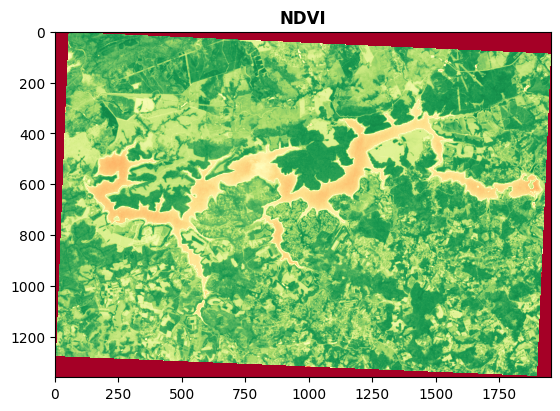

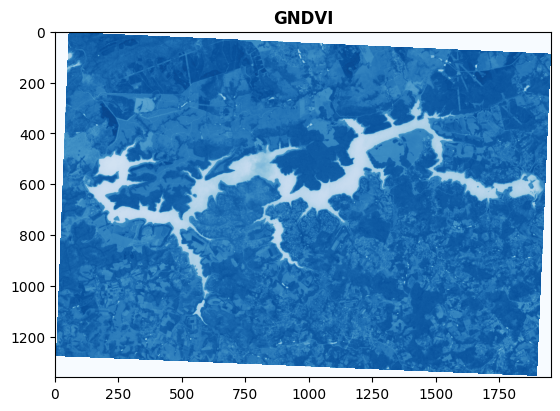

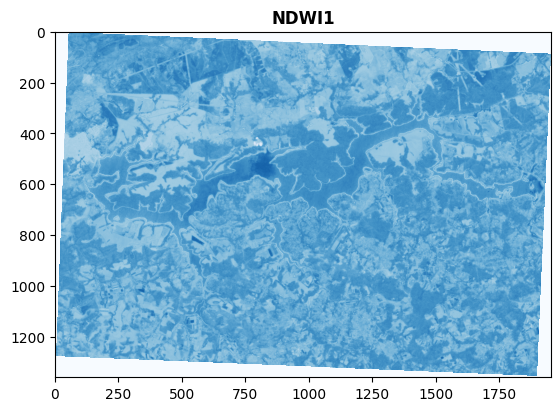

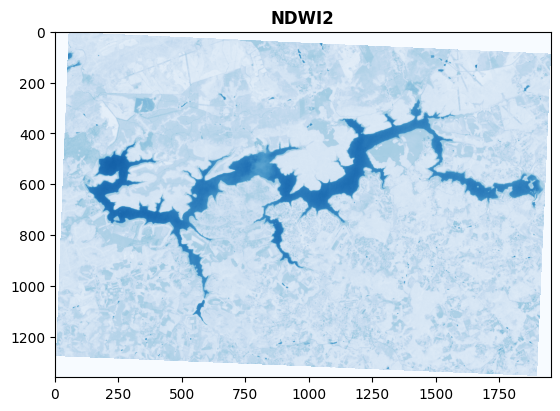

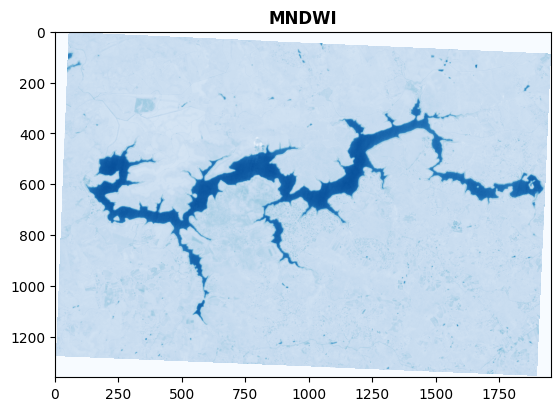

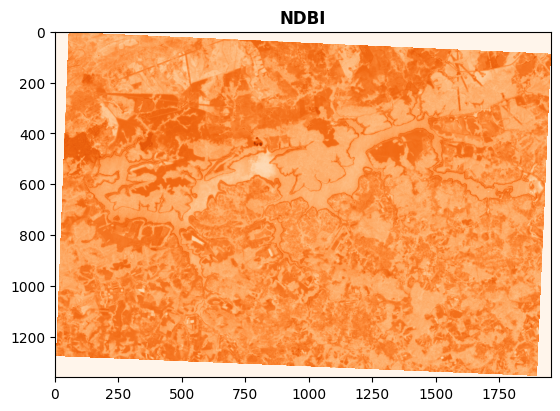

In [ ]:
NDVI = NDVI(CROP_ITUPARARANGA_PATH,NDVI_PATH)

GNDVI = GNDVI(CROP_ITUPARARANGA_PATH,GNDVI_PATH)

NDWI1 = NDWI1(CROP_ITUPARARANGA_PATH,NDWI1_PATH)

NDWI2 = NDWI2(CROP_ITUPARARANGA_PATH,NDWI2_PATH)

MNDWI = MNDWI(CROP_ITUPARARANGA_PATH,MNDWI_PATH)

NDBI = NDBI(CROP_ITUPARARANGA_PATH,NDBI_PATH)

In [ ]:
ds = gdal.Open(NDVI_PATH)
if ds is None:
  print(f"The file {ds} could not be opened")
  sys.exit(-1)




transformRaster = ds.GetGeoTransform()
afnRaster = Affine.from_gdal(*transformRaster)

crsRaster = ds.GetProjectionRef()

print(f"NDVI CRS: {crsRaster}")

NDVI CRS: PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]


NDVI MEAN -84.17317199707031
NDVI STD 278.3081970214844


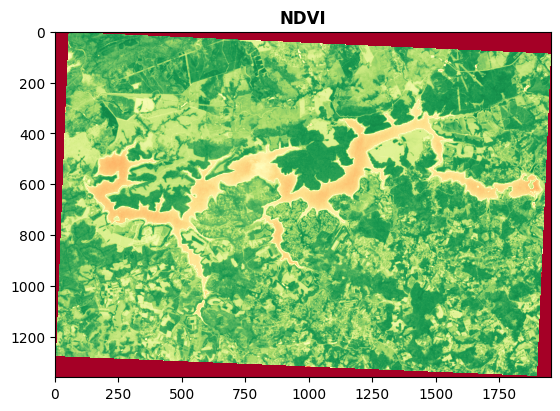

In [ ]:
NDVI = NDVI(CROP_ITUPARARANGA_PATH,NDVI_PATH)

In [ ]:
#Close the STUDY_AREA raster file
STUDY_AREA = None

####**Merge of the raster image with 10 bands with the calculated vegetation indexes.**

As a result, a new raster image is obtained that will be
composed of 16 bands (10 original spectral bands + 6 vegetation indexes).

In [ ]:
CROP_ITUPARARANGA_VEGETATION_INDEX_PATH = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/STACK_16/STACK_ITUPARARANGA_VEGETATION_INDEX.tiff"


In [ ]:

#We create a new raster file that will get the origial bands of the raster STUDY_AREA and the additional vegetation index
#For that, we need to extract the metadata of the original raster file to use for the new raster file
# Open the existing STUDY_AREA raster in read mode
with rasterio.open(CROP_ITUPARARANGA_PATH, 'r') as src:

    # Define a list of index arrays and their paths
    index_arrays = [NDVI, GNDVI, NDWI1, NDWI2, MNDWI, NDBI]
    index_paths = [NDVI_PATH, GNDVI_PATH, NDWI1_PATH, NDWI2_PATH, MNDWI_PATH, NDBI_PATH]

    # Get the existing metadata and update count for the new bands
    meta = src.meta
    meta.update(count=src.count + len(index_arrays), dtype=index_arrays[0].dtype)

    # Create an empty array to store the new bands
    new_data = np.empty((meta['count'], meta['height'], meta['width']), dtype=meta['dtype'])

    # Copy the existing bands to the new array
    for i in range(src.count):
        new_data[i] = src.read(i + 1)  # Band indexing starts from 1

    # Add the calculated index arrays to the new array
    for i, index_array in enumerate(index_arrays):
        new_data[src.count + i] = index_array

    # Open the existing raster in write mode and write the new array
    with rasterio.open(CROP_ITUPARARANGA_VEGETATION_INDEX_PATH, 'w', **meta) as dst:
        for i in range(meta['count']):
            dst.write(new_data[i], i + 1)  # Band indexing starts from 1


dst.close()



###**Fourth Step**

####**Load the new raster file known as STACK_ITUPARARANGA_VEGETATION_INDEX.tiff. It has 16 bands.**

In [ ]:
#CROP_ITUPARARANGA_VEGETATION_INDEX_PATH = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/STACK_ITUPARARANGA_VEGETATION_INDEX_WITHOUT_NO_DATA.tif"

#CROP_ITUPARARANGA_VEGETATION_INDEX_PATH = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/STACK_ITUPARARANGA_VEGETATION_INDEX.tiff"


STACK_VEGETATION_INDEX = gdal.Open(CROP_ITUPARARANGA_VEGETATION_INDEX_PATH)
invalid_file(STACK_VEGETATION_INDEX)

#Get the number of bands
print("Number of bands {nbbands}".format(nbbands=STACK_VEGETATION_INDEX.RasterCount))

#Get the number of rows and columns
nrcols = STACK_VEGETATION_INDEX.RasterXSize
nrows = STACK_VEGETATION_INDEX.RasterYSize
print("Number of rows {rows} and Number of columns {cols}".format(rows=nrows,cols=nrcols))

#Get the projection and the extent
proj = STACK_VEGETATION_INDEX.GetProjectionRef()
extent = STACK_VEGETATION_INDEX.GetGeoTransform()
print("Projection of the image is {proj}".format(proj=proj))
print("Extent of the image is {ext}".format(ext=extent))

index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for j in index:
  band = STACK_VEGETATION_INDEX.GetRasterBand(j)
  min = band.GetMinimum()
  max = band.GetMaximum()
  if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
  print("Band {band}: Min {minimum_value} Max {maximum_value}".format(band=j, minimum_value= min,maximum_value=max))


#Close the raster image
STACK_VEGETATION_INDEX = None

Number of bands 16
Number of rows 1361 and Number of columns 1953
Projection of the image is PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]
Extent of the image is (865790.0, 10.0, 0.0, 7389100.0, 0.0, -10.0)
Band 1: Min 0.0 Max 3348.0
Band 2: Min 0.0 Max 3334.0
Band 3: Min 0.0 Max 4464.0
Band 4: Min 0.0 Max 4998.0
Band 5: Min 0.0 Max 5348.0
Band 6: Min 0.0 Max 6116.0
Band 7: Min 0.0 Max 6068.0
Band 8: Min 0.0 Max 6114.0
Band 9: Min 0.0 M

**Rasterize the shapefile that contains the ground data sample**

In [ ]:
sample_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/SAMPLE_DATA.tiff"
SAMPLE_PATH = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/SAMPLE_POINTS_CROP_ITUPARARANGA.shp"


In [ ]:

#Creation of a raster dataset
#This is the path for the raster dataset for the shapefile SAMPLE
#sample_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/SAMPLE_DATA_V2.tiff"
sample_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/SAMPLE_DATA.tiff"
driverTiff = gdal.GetDriverByName('GTiff')


output_raster_dataset = driverTiff.Create(sample_fn,nrcols,nrows,1,gdal.GDT_UInt16)

#Set the ROI image's projection and extent to our input raster's projection and extent
output_raster_dataset.SetProjection(proj)
output_raster_dataset.SetGeoTransform(extent)

# #Fill the output band with the 0 blank, no class class label, value
# b = output_raster_dataset.GetRasterBand(1)
# b.Fill(0)

#Rasterize the shapefile layer to our new dataset
#IMPORT THE TRAINING POINTS (SHAPEFILE)
SAMPLE_PATH = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/DOCUMENTS/SAMPLE_POINTS_CROP_ITUPARARANGA.shp"

SAMPLE = ogr.Open(SAMPLE_PATH)
invalid_file(SAMPLE)



layer_count = SAMPLE.GetLayerCount()
print(f"The shapefile has {layer_count} layer")
layer = SAMPLE.GetLayerByIndex(0)
#print(layer.index)
print(layer)
### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))




for feature in layer:
    # Get the attributes of the feature
    attributes = feature.items()

    # Print the attributes

    print(attributes)


for feature in layer:
    class_id = feature.GetField('id')
    class_label = feature.GetField('Classe')
    print(f"Class ID: {class_id}, Class Label: {class_label}")




The shapefile has 1 layer
<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7e8e6ec026d0> >
Layer has 540 features

Layer has 2 fields
Their names are: 
	id - Real
	Classe - String
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe': 'agricultura'}
{'id': 1.0, 'Classe'

In [ ]:

status = gdal.RasterizeLayer(
    output_raster_dataset, #output of our new dataset
    [1], #output of our new dataset first band
    layer, #Rasterize this layer
    None, None,  #We are in the same projection, so we don't need to change the transformation
    [0], #burn value 0
    ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
    'ATTRIBUTE=id']  # put raster values according to the 'id' field values
)



#Close the dataset that will keep our shapefile
output_raster_dataset = None


#Check if the rasterization of the shapefile to the raster worked or not
if status !=0:
    print("The rasterization did not work !")
else:
    print('The rasterization was successful !')



The rasterization was successful !


####**Roi**

#####**Load the rasterized shapefile**

In [ ]:
roi_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/SAMPLE_DATA.tiff"


min 0 max 9 mean 0.02405726339740703
(1361, 1953)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classe 0 contains 2645096 pixels
Classe 1 contains 1576 pixels
Classe 2 contains 1419 pixels
Classe 3 contains 1618 pixels
Classe 4 contains 1401 pixels
Classe 5 contains 1109 pixels
Classe 6 contains 1450 pixels
Classe 7 contains 1418 pixels
Classe 8 contains 1612 pixels
Classe 9 contains 1334 pixels
(1361, 1953, 16)


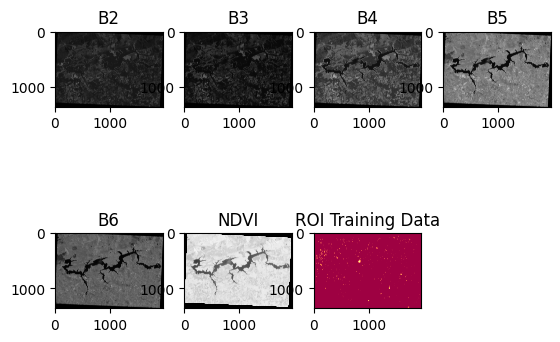

In [ ]:
#roi_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/SAMPLE_DATA_V2.tiff"

roi_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/SAMPLE_DATA.tiff"


roi_dataset = gdal.Open(roi_fn)
roi = roi_dataset.GetRasterBand(1).ReadAsArray()

print("min", roi.min(), "max", roi.max(), "mean", roi.mean())
print(roi.shape)
print(roi)
print(roi)

classes = np.unique(roi)

for classe in classes:
    print("Classe {classe} contains {n} pixels".format(classe=classe, n= (roi == classe).sum()))

STACK_VEGETATION_INDEX = gdal.Open(CROP_ITUPARARANGA_VEGETATION_INDEX_PATH)
invalid_file(STACK_VEGETATION_INDEX)



img = np.zeros((STACK_VEGETATION_INDEX.RasterYSize, STACK_VEGETATION_INDEX.RasterXSize, STACK_VEGETATION_INDEX.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(STACK_VEGETATION_INDEX.GetRasterBand(1).DataType))

print(img.shape)




for b in range(img.shape[2]):
    img[:, :, b] = STACK_VEGETATION_INDEX.GetRasterBand(b + 1).ReadAsArray() #1-based index


roi = roi.astype(np.uint8)

# Display them
plt.subplot(241)
plt.imshow(img[:, :, 1], cmap=plt.cm.Greys_r)
plt.title('B2')

plt.subplot(242)
plt.imshow(img[:, :, 2], cmap=plt.cm.Greys_r)
plt.title('B3')

plt.subplot(243)
plt.imshow(img[:, :, 3], cmap=plt.cm.Greys_r)
plt.title('B4')

plt.subplot(244)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('B5')

plt.subplot(245)
plt.imshow(img[:, :, 6], cmap=plt.cm.Greys_r)
plt.title('B6')

plt.subplot(246)
plt.imshow(img[:, :, 11], cmap=plt.cm.Greys_r, vmin=-1,vmax=1)
plt.title('NDVI')



plt.subplot(247)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

#####**Pairing of X (features) with Y (labels)**

**Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data)
We need to pair them up in NumPy arrays so we may feed them to Random Forest**

In [ ]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))


# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]
y = roi[roi > 0]


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 12937 samples
The training data include 9 classes: [1 2 3 4 5 6 7 8 9]
Our X matrix is sized: (12937, 16)
Our y array is sized: (12937,)


In [ ]:
print(roi.shape)
STACK_VEGETATION_INDEX_ARRAY = STACK_VEGETATION_INDEX.ReadAsArray()
print(STACK_VEGETATION_INDEX_ARRAY.shape)




(1361, 1953)


###**Fith Step: Training the Random Forest**

####**Training the Random Forest model**

In [ ]:
# Split data into training (70%) and validation (30%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=700, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

print('1) Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

print('2) Our OOB prediction of accuracy is: {oob}'.format(oob=rf.oob_score_))


####**Feature importance**

In [ ]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Initialize variables to track the highest importance value and corresponding band
highest_importance = 0
highest_band = None



#Check which bands help the most in the prediction
for j in range(len(bands)):
    b = bands[j]
    imp = rf.feature_importances_[j]

    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

    # Check if the current importance is higher than the previous highest
    if imp > highest_importance:
        highest_importance = imp
        highest_band = b


feature_importances_mean = rf.feature_importances_.mean()
feature_importances_std = rf.feature_importances_.std()
print("Feature importance MEAN {mean} and STD {std}".format(mean=feature_importances_mean,std=feature_importances_std))

# Set a threshold for importance to filter bands
importance_threshold = feature_importances_mean

# Filter bands with importance greater than or equal to the threshold
important_bands = [b for b, imp in zip(bands, rf.feature_importances_) if imp >= importance_threshold]

# Display the bands with importance values above the threshold
print('Bands with importance greater than or equal to {threshold}: {bands}'.format(
    threshold=importance_threshold, bands=important_bands))




Band 1 importance: 0.05405411593914739
Band 2 importance: 0.062062146466233925
Band 3 importance: 0.07226815206377457
Band 4 importance: 0.06652324554401039
Band 5 importance: 0.10574737550046963
Band 6 importance: 0.07188268391751428
Band 7 importance: 0.056381176324041125
Band 8 importance: 0.05578617681537988
Band 9 importance: 0.042378712572936184
Band 10 importance: 0.04782783095792973
Band 11 importance: 0.06485147644277553
Band 12 importance: 0.07097399854940507
Band 13 importance: 0.04517577222160214
Band 14 importance: 0.07900601332432103
Band 15 importance: 0.06093933921474693
Band 16 importance: 0.044141784145712355
Feature importance MEAN 0.0625 and STD 0.015478871856620413
Bands with importance greater than or equal to 0.0625: [3, 4, 5, 6, 11, 12, 14]


####**Confusion Matrix**

In [ ]:
#Confusion Matrix for the Prediction in the Training Phase
#Create a dataframe

df = pd.DataFrame()
df["truth"] = y_train
df["predict"] = rf.predict(X_train)

confusion_matrix_train_df = pd.crosstab(df["predict"],df["truth"], margins=True)
print(confusion_matrix_train_df)

truth       1    2     3    4    5     6    7     8    9   All
predict                                                       
1        1128    0     0    0    0     0    0     0    0  1128
2           0  976     0    0    0     0    0     0    0   976
3           0    0  1119    0    0     0    0     0    0  1119
4           0    0     0  982    0     0    0     0    0   982
5           0    0     0    0  788     0    0     0    0   788
6           0    0     0    0    0  1024    0     0    0  1024
7           0    0     0    0    0     0  976     0    0   976
8           0    0     0    0    0     0    0  1129    0  1129
9           0    0     0    0    0     0    0     0  933   933
All      1128  976  1119  982  788  1024  976  1129  933  9055


In [ ]:
#Confusion Matrix for the Prediction in the Validation Phase
#Create a dataframe

df2 = pd.DataFrame()
df2["truth"] = y_valid
df2["predict"] = rf.predict(X_valid)

confusion_matrix_va_df = pd.crosstab(df2["truth"],df2["predict"], margins=True)
print(confusion_matrix_va_df)


cm_va = confusion_matrix_va_df.values
print(cm_va.shape)

predict    1    2    3    4    5    6    7    8    9   All
truth                                                     
1        430    8    0    0    0    1    1    0    8   448
2          0  443    0    0    0    0    0    0    0   443
3          0    0  487   10    0    2    0    0    0   499
4          0    0    4  415    0    0    0    0    0   419
5          0    0    0    0  319    2    0    0    0   321
6          0    0    5    0   11  407    2    0    1   426
7          0    0    0    0    0    3  438    1    0   442
8          0    0    0    0    0    0   19  455    9   483
9          0    0    0    0    0    3    3    8  387   401
All      430  451  496  425  330  418  463  464  405  3882
(10, 10)


In [ ]:
y_pred = rf.predict(X_valid)
print(y_pred.shape)
Accuracy = accuracy_score(y_valid,y_pred)*100
print(f"Accuracy : {Accuracy}%")

(3882,)
Accuracy : 97.39824832560537%


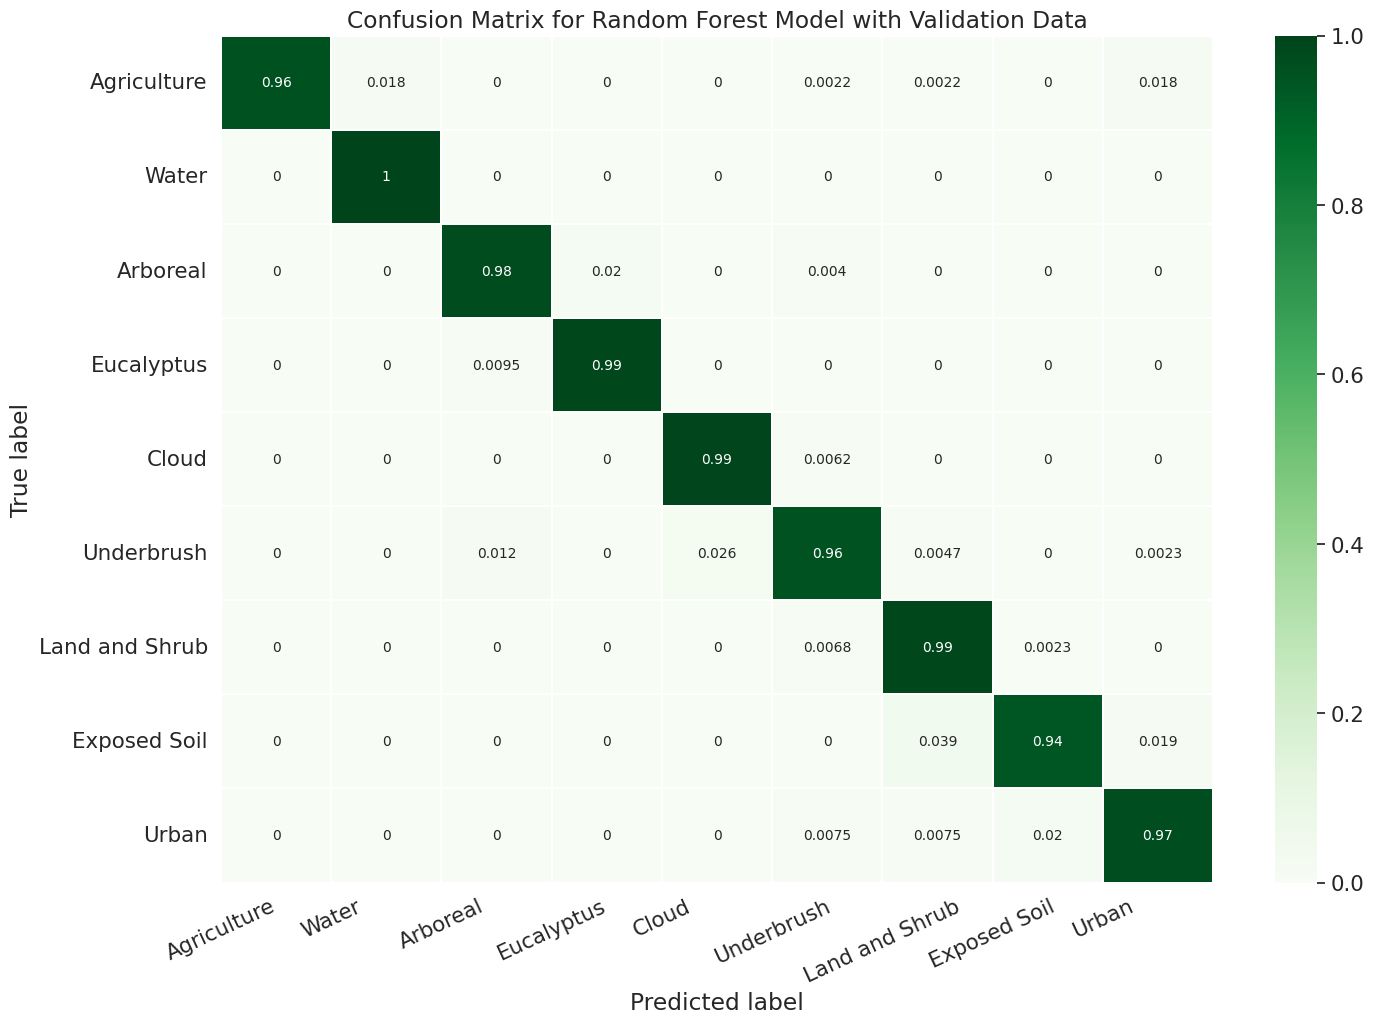

In [ ]:

#Get and reshape of the confusion matrix data for better visualization
matrix_validation = confusion_matrix(y_valid,y_pred)
matrix_validation = matrix_validation.astype("float") / matrix_validation.sum(axis=1)[:, np.newaxis]


#Build the plot
plt.figure(figsize=(16,11))
sns.set(font_scale=1.4)
sns.heatmap(matrix_validation, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Agriculture', 'Water', 'Arboreal',
               'Eucalyptus', 'Cloud', 'Underbrush',
               'Land and Shrub', 'Exposed Soil', 'Urban']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model with Validation Data')
plt.savefig("/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/CONFUSION_MATRIX_VALIDATION_DATA.jpg") #save as png
plt.show()


In [ ]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98       448
           2       0.98      1.00      0.99       443
           3       0.98      0.98      0.98       499
           4       0.98      0.99      0.98       419
           5       0.97      0.99      0.98       321
           6       0.97      0.96      0.96       426
           7       0.95      0.99      0.97       442
           8       0.98      0.94      0.96       483
           9       0.96      0.97      0.96       401

    accuracy                           0.97      3882
   macro avg       0.97      0.97      0.97      3882
weighted avg       0.97      0.97      0.97      3882



####**OOB Error**

###**Sixth Step: Classification of the entire study area**

In [ ]:
#Convert the raster object to a numpy array
#STACK_VEGETATION_INDEX_ARRAY represent the study area with 16 bands
#The study area is the area around the dam of itupararanga

STACK_VEGETATION_INDEX_ARRAY = STACK_VEGETATION_INDEX.ReadAsArray()
print("Dimension for band_data: {shape}".format(shape=STACK_VEGETATION_INDEX_ARRAY.shape))

Dimension for band_data: (16, 1361, 1953)


In [ ]:
band_data = []
band_data = np.dstack(STACK_VEGETATION_INDEX_ARRAY)
print("Dimension for band_data: {shape}".format(shape=band_data.shape))

Dimension for band_data: (1361, 1953, 16)


In [ ]:
#Reshape the raster file in a 2d array format
new_dimension =(band_data.shape[0] * band_data.shape[1],band_data.shape[2])
print(new_dimension)
image_stack_2d = band_data.reshape(new_dimension)
print(image_stack_2d.shape)

print("Reshaped from {original} to {new}".format(original=band_data.shape,new=image_stack_2d.shape))

(2658033, 16)
(2658033, 16)
Reshaped from (1361, 1953, 16) to (2658033, 16)


####**Prediction for each pixel in the entire study area image**

In [ ]:
#Now we predict for each pixel of the wall image
real_image_prediction = rf.predict(image_stack_2d)

In [ ]:
print(real_image_prediction.shape)

# Reshape our classification map
class_prediction = real_image_prediction.reshape(band_data[:, :, 0].shape)
print("Reshaped from {original} to {new} for our classification map".format(original=real_image_prediction.shape,new=class_prediction.shape))

(2658033,)
Reshaped from (2658033,) to (1361, 1953) for our classification map


####**Export the classification map to the tiff format**

In [ ]:
classification_map_fn = "/content/drive/MyDrive/ESIEA/ESIEA_4A/Internship/Landcover_Classification_RF_ITUPARARANGA/SENTINEL 2/IMAGES/CUT_IMAGES/CLASSIFICATION_MAP_V2.tiff"

In [ ]:
# OPEN THE FINAL RASTER FILE OF THE AREA OF STUDY
STACK_VEGETATION_INDEX_RASTERIO  = rasterio.open(CROP_ITUPARARANGA_VEGETATION_INDEX_PATH)

#CHECK IF THE FILE WAS CORRECTLY OPENED
invalid_file(STACK_VEGETATION_INDEX_RASTERIO)
print(STACK_VEGETATION_INDEX_RASTERIO.crs)
print(STACK_VEGETATION_INDEX_RASTERIO.transform)


EPSG:32722
| 10.00, 0.00, 865790.00|
| 0.00,-10.00, 7389100.00|
| 0.00, 0.00, 1.00|


In [ ]:
##Create a rasterio dataset and save the numpy array class_prediction as a tiff file
with rasterio.open(
            classification_map_fn,
            'w',
            driver='GTiff',
            height=class_prediction.shape[0],
            width=class_prediction.shape[1],
            count=1,
            dtype=class_prediction.dtype,
            crs=STACK_VEGETATION_INDEX_RASTERIO.crs,
            transform=STACK_VEGETATION_INDEX_RASTERIO.transform,
    ) as dst:
    dst.write(class_prediction,1)